In [39]:
%matplotlib inline
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output; 
import time
import logging; 
logging.getLogger('FFC').setLevel(logging.WARNING)

# Compact plot utility function
def plot_compact(u, t, stepcounter, V, pl, ax): 
    if stepcounter % 5 == 0:
        uEuclidnorm = project(u, V)
        ax.cla()
        fig = plt.gcf()
        fig.set_size_inches(16, 6.5)
        plt.subplot(1, 2, 1); mplot_function(uEuclidnorm); plt.title("Heat") # Plot norm of velocity
        if t == 0.:  plt.colorbar(); plt.axis(G)

        plt.subplot(1, 2, 2);
        if t == 0.:  
          plt.triplot(mesh2triang(mesh)); plt.title("Mesh") # Plot mesh
        plt.suptitle("Heat - t: %f" % (t)); plt.tight_layout(); clear_output(wait=True);
        display(pl)
    return pl, ax

In [14]:
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def mplot_cellfunction(cellfn):
    C = cellfn.array()
    tri = mesh2triang(cellfn.mesh())
    return plt.tripcolor(tri, facecolors=C)

def mplot_function(f):
    mesh = f.function_space().mesh()
    if (mesh.geometry().dim() != 2):
        raise AttributeError('Mesh must be 2D')
    # DG0 cellwise function
    if f.vector().size() == mesh.num_cells():
        C = f.vector().array()
        return plt.tripcolor(mesh2triang(mesh), C)
    # Scalar function, interpolated to vertices
    elif f.value_rank() == 0:
        C = f.compute_vertex_values(mesh)
        return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    # Vector function, interpolated to vertices
    elif f.value_rank() == 1:
        w0 = f.compute_vertex_values(mesh)
        if (len(w0) != 2*mesh.num_vertices()):
            raise AttributeError('Vector field must be 2D')
        X = mesh.coordinates()[:, 0]
        Y = mesh.coordinates()[:, 1]
        U = w0[:mesh.num_vertices()]
        V = w0[mesh.num_vertices():]
        return plt.quiver(X,Y,U,V)

# Plot a generic dolfin object (if supported)
def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, Function):
        return mplot_function(obj)
    elif isinstance(obj, CellFunctionSizet):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionDouble):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionInt):
        return mplot_cellfunction(obj)
    elif isinstance(obj, Mesh):
        if (obj.geometry().dim() != 2):
            raise AttributeError('Mesh must be 2D')
        return plt.triplot(mesh2triang(obj), color='#808080')

    raise AttributeError('Failed to plot %s'%type(obj))

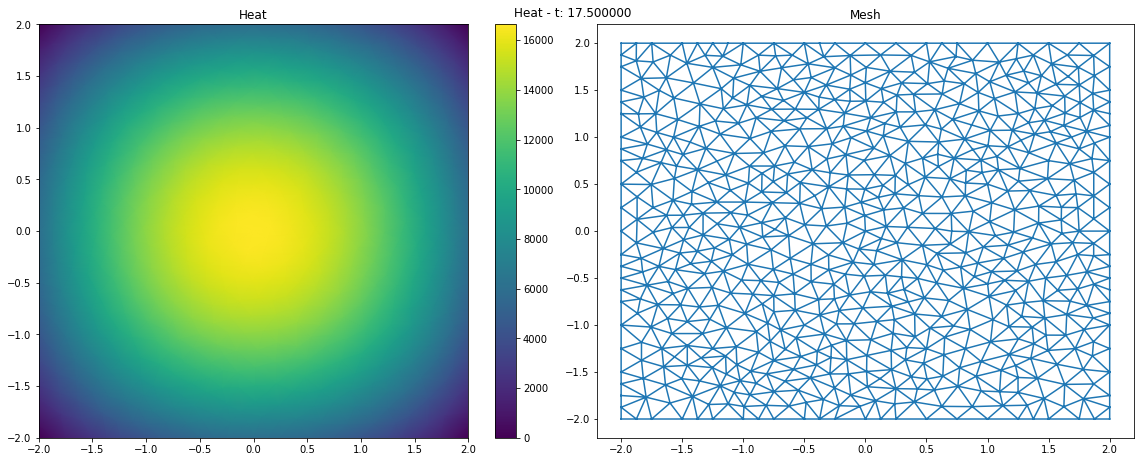

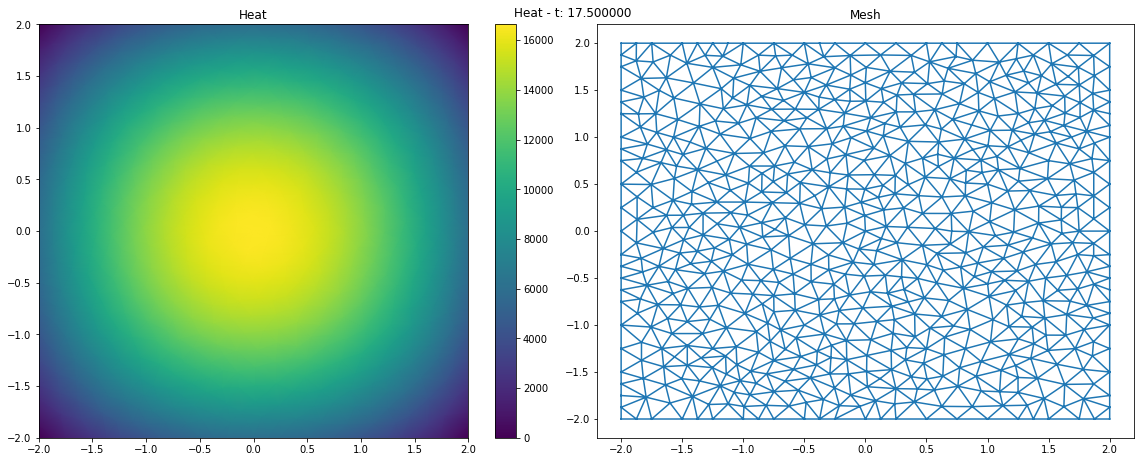

In [19]:
XMIN, XMAX = -2., 2.; 
YMIN, YMAX = -2., 2.; 
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 20;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define finite element function space
degree = 1;
V = FunctionSpace(mesh, "CG", degree);

# Finite element functions
v = TestFunction(V); 
u = Function(V);

# Define boundary conditions
def boundary(x, on_boundary):
    return on_boundary

# Time parameters
theta = 1.0 # Implicit Euler
k = 0.5; # Time step
t, T = 0., 20.; # Start and end time

# Exact solution
k_coeff = 1
ue = Expression("exp(-(x[0]*x[0]+x[1]*x[1])/(4*a*t))/(4*pi*a*t)", a=k_coeff, t=1e-7, domain=mesh, degree=degree) 
u0 = ue;

bc = DirichletBC(V, ue, boundary)

# Inititalize time stepping
pl, ax = plt.subplots();
stepcounter = 0;

# Time-stepping loop
while t < T: 
    # Time scheme
    um = theta*u + (1.0-theta)*u0 
    
    # Weak form of the heat equation in residual form
    r = (u - u0)/k*v*dx + k_coeff*inner(grad(um), grad(v))*dx 
    
    # Solve the Heat equation (one timestep)
    solve(r==0, u, bc)  
    
    # Plot all quantities (see implementation above)
    pl, ax = plot_compact(u, t, stepcounter, pl, ax)
    
    # Shift to next timestep
    t += k; 
    hou0 = project(u, V); 
    ue.t = t;
    stepcounter += 1 

In [18]:
e1 = assemble((ue-u0)*(ue-u0)*dx)
e2 = assemble(ue*ue*dx)
re = sqrt(e1/e2);
print ("Relative L2_error = {}".format(re))

Relative L2_error = 0.028271236280296812


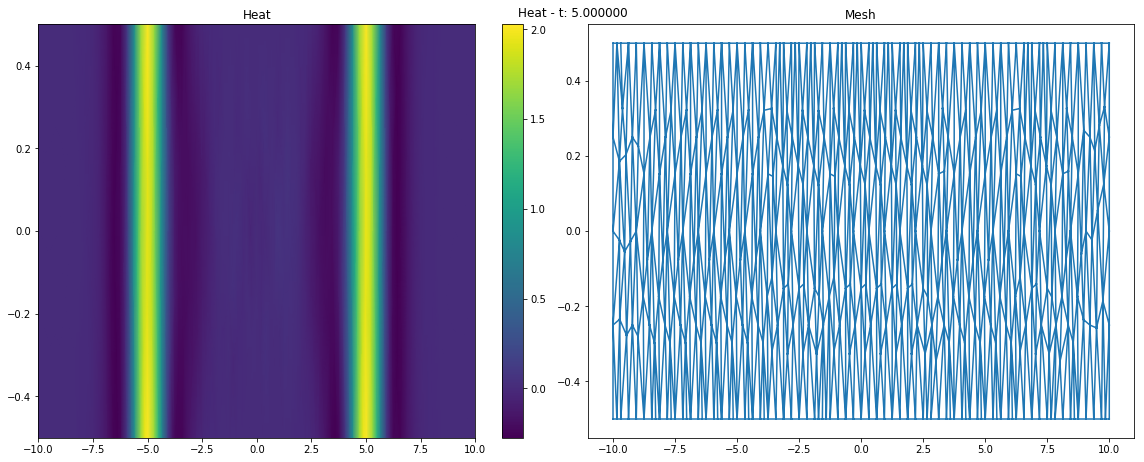

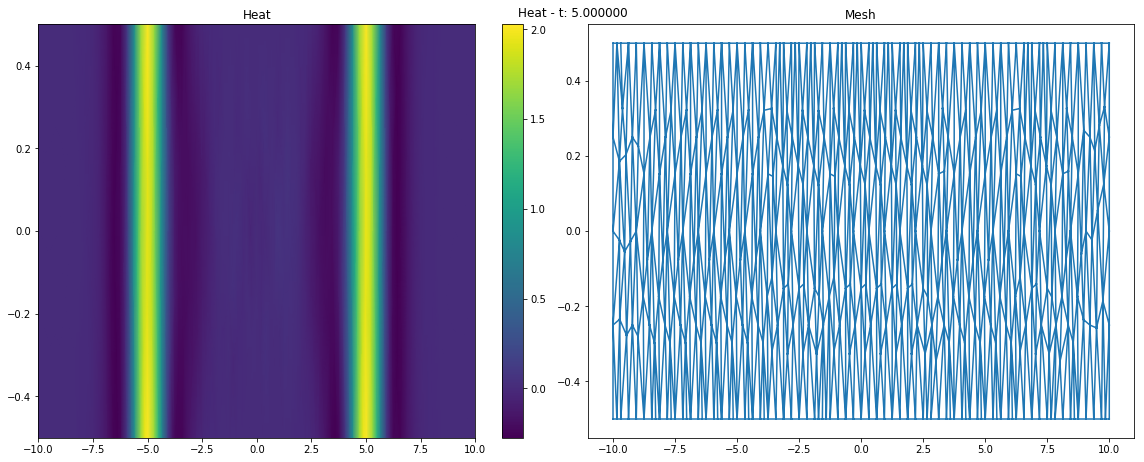

In [35]:
# Define domain and mesh
XMIN, XMAX = -10., 10.;
YMIN, YMAX = -0.5, 0.5;
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 50;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define function spaces and functions
degree=1
Ve = FiniteElement("CG", mesh.ufl_cell(), degree)
Q = FunctionSpace(mesh,Ve);
TH = MixedElement([Ve,Ve])
W = FunctionSpace(mesh, TH)
(p, q) = TestFunctions(W); 
w = Function(W); 
(u, v) = (w[0], w[1]);
u0 = Function(Q); 
v0 = Function(Q);

# Time interval and time step
t, T = 0., 5.;
k = 0.05;
a = 1;

# Define the Dirichlet boundary   
def boundary(x, on_boundary):                                                                                                                                                                                                 
    return on_boundary

# Initial solution
option = 0;
if option==0:
    ue = Expression("(1-pow(a*t-x[0],2))*exp(-pow(a*t-x[0],2)) + (1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh, degree=degree+1);
    ve = Expression("2*a*(a*t-x[0])*(pow(a*t-x[0],2)-2)*exp(-pow(a*t-x[0],2)) + 2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh, degree=degree+1)
if option==1:
    ue = Expression("(1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh, degree=degree);
    ve = Expression("2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh, degree=degree+1)

# Boundary conditions
bcu = DirichletBC(W.sub(0), ue, boundary)
bcv = DirichletBC(W.sub(1), ve, boundary)
bcs = [bcu, bcv];

# Initial solution
u0 = ue;
v0 = ve;

# Time scheme parameter
theta = 0.5;

# Inititalize time stepping
pl, ax = plt.subplots();
stepcounter = 0; 

# Time-stepping loop    
while t < T:
    # Weak form of wave equation
    vm = theta*v + (1.0-theta)*v0;
    um = theta*u + (1.0-theta)*u0;
    ru=(u-u0)/k*p*dx - vm*p*dx
    rv=(v-v0)/k*q*dx + a*a*inner(grad(um),grad(q))*dx
    r = ru + rv;
    ue.t = t;
    ve.t = t;
    
    # Solve the wave equation (one time step)
    solve(r==0, w, bcs);
    
    # Shift to next timestep                                                     
    u0 = project(u, Q);
    v0 = project(v, Q);
    
    # Visualize the solution
    pl, ax=plot_compact(u0, t, stepcounter, Q, pl, ax)
    t += k;
    stepcounter += 1;

In [36]:
e1 = assemble((ue-u0)*(ue-u0)*dx)
e2 = assemble(ue*ue*dx)
re = sqrt(e1/e2);
print ("Relative L2_error = {}".format(re))

Relative L2_error = 0.06911259522982496


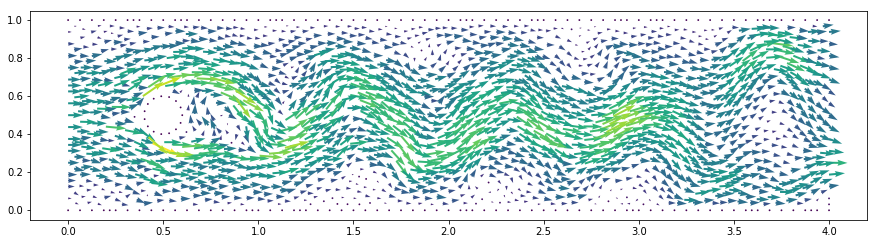

In [49]:
# Generate domain and mesh
XMIN = 0.; 
XMAX = 4.; 
YMIN = 0; 
YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
eps = 1e-5

mresolution = 50

SEGMENTS = 15;
circle = Circle(Point(.5, .5), .1, SEGMENTS)

mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - circle, mresolution)
# FEM function spaces and functions
degree=1
Qe = FiniteElement("CG", mesh.ufl_cell(), degree)
Q = FunctionSpace(mesh,Qe);

Ve = VectorElement("CG", mesh.ufl_cell(), degree)
V = FunctionSpace(mesh,Ve);

TH = MixedElement([Ve,Qe])
W = FunctionSpace(mesh, TH)

h = 0.5*CellDiameter(mesh);
(v, q) = TestFunctions(W);
w = Function(W); 
(u, p) = (as_vector((w[0], w[1])), w[2]); 
u0 = Function(V)

# Inlet velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, degree=degree+1) 
# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, degree=degree) 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, degree=degree)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, degree=degree)

# Timestep, viscosity and stabilization parameters
k = 0.1; 
d = .2*h**(3./2.) 

# Time interval and penalty parameter
t, T = 0., 10.; 
gamma = 10*1./h 

pl, ax = None, None; 

# Initialize time stepping
stepcounter = 0; 
#pl, ax = plt.subplots();

# Time stepping method
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
# Time-stepping loop
while t < T: 
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)  

    # Visualize the solution
    #pl, ax=plot_compact(u0, t, stepcounter, Q, pl, ax) # Plot all quantities (see implementation above)
    #plt.figure(figsize = (15,7))
    #ax = plot(u0)
    
    # Shift to next timestep
    t += k; 
    stepcounter += 1; 
    u0 = project(u, V);
    
plt.figure(figsize = (15,7))
ax = plot(u0)

In [45]:
L2u_norm = sqrt(assemble(inner(u, u)*dx));
print ("L2 norm = {}".format(L2u_norm))

L2 norm = 1.572015001501878


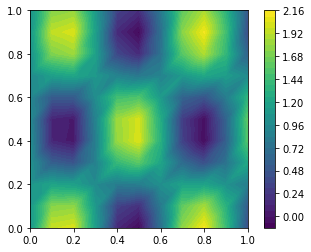

In [53]:
# Declare mesh and FEM functions
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, "CG", 1)
f = Expression("1. + sin(10*x[0])*cos(7*x[1])", degree=3)
v = TestFunction(V)
u = Function(V) # FEM solution

# Weak form of L2 projection
r = (u - f)*v*dx

# Solving the linear system generated by the L2 projection
solve(r == 0, u)

# Plot the FEM solution
pp = plot(u)
ax = plt.colorbar(pp)

In [59]:
u.vector().norm('linf')

2.117554578939405

phi = Function(V)
phi.vector()[:] = 0.0
phi.vector()[12] = 1.
ax = plot(phi)

In [66]:
assemble(phi*phi*dx)

0.005000000000000003

In [84]:
a, b = 0, 1
mresolution = 20
mesh = IntervalMesh(mresolution, a, b)

# Define finite element function space
p_order = 1;
V = FunctionSpace(mesh, "CG", p_order)
hoho
# Express the "exact" reference function
u = Expression("1 + sin(10*x[0])", degree=5)

# Interpolate u onto V
Iu = interpolate(u, V)

# Project u onto V
Pu = project(u, V)

In [86]:
[sqrt(assemble((Pu - u)*(Pu - u)*dx)), sqrt(assemble((Iu - u)*(Iu - u)*dx))]

[0.006631626929298547, 0.015663662247594107]